Connected to MLP_projekt (Python 3.13.9)

<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:13: SyntaxWarning: invalid escape sequence '\o'
<ipython-input-1-c224b0b78aec>:13: SyntaxWarning: invalid escape sequence '\o'
  - files on folder: '\old_ML_procect_files\'
c:\Users\tgmin\anaconda3\envs\MLP_projekt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----------------------------------------
Data raw
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 

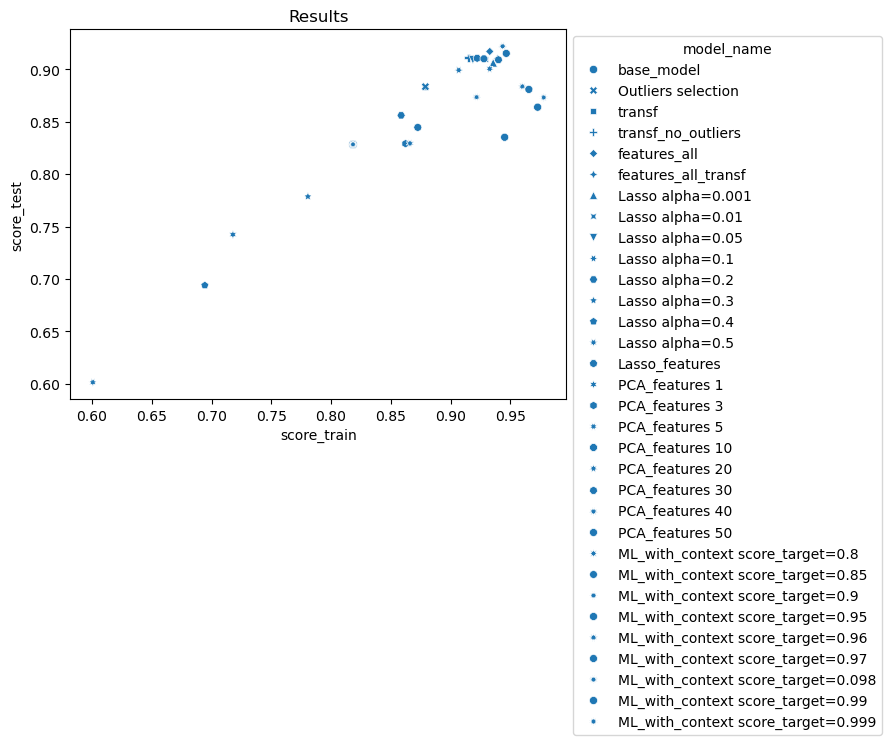

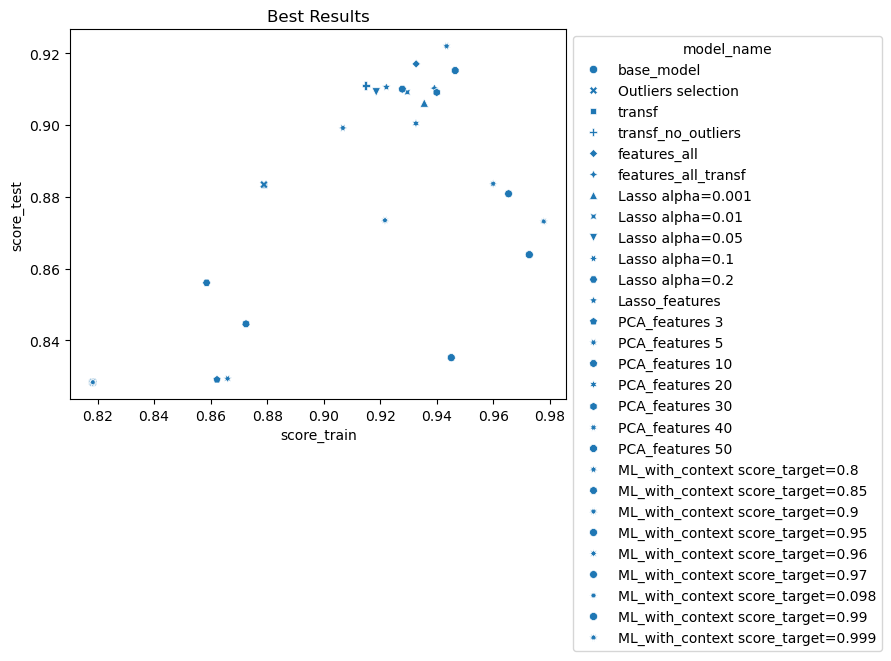

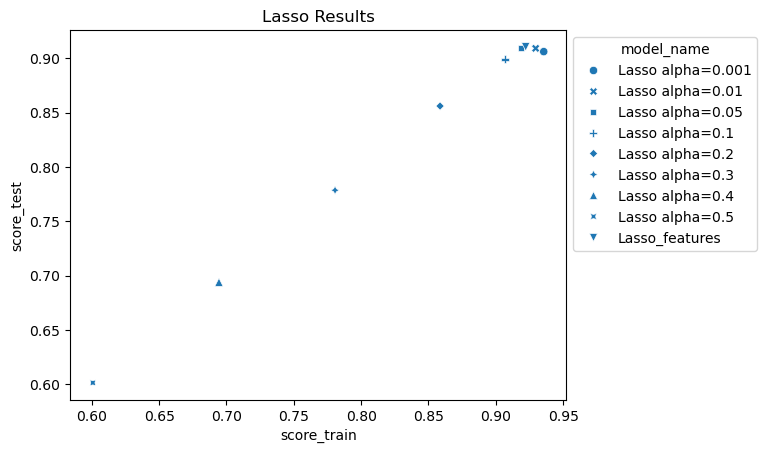

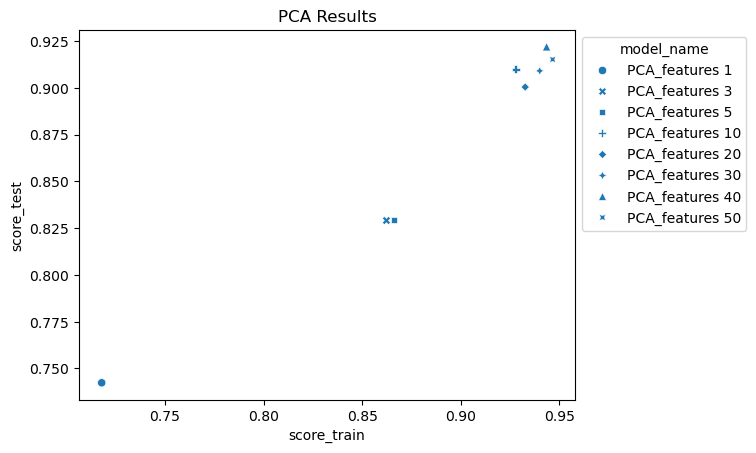

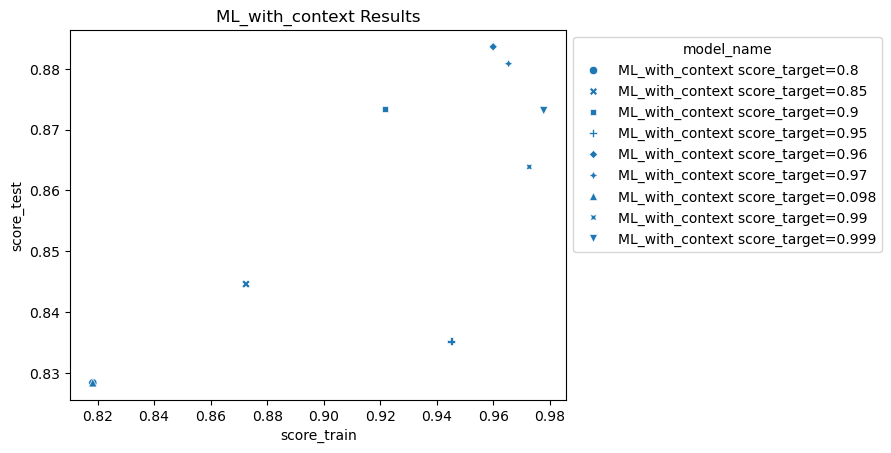

In [ ]:
''' MLP project

main file special

Paweł Józefczyk
Tomasz Gmiński

data file: 'cars.csv'
target_column: 'mpg' - miles per galon

As preliminary Project ML was used.
    - github repository: https://github.com/tgminski/Projekt_ML_final
    - files on folder: '\old_ML_procect_files\'

'''


# import libraries
import utilites_TG
import utilites_PJ
#from TG_ML_clustering_utilities import TG_data_normalize_stats, TG_clustering_ml
from TG_ML_clustering_utilities import TG_ML_with_context

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

import shap

import warnings
#warnings.filterwarnings("ignore")

def main():
    #pd.options.mode.chained_assignment = None  # default='warn'
    target = 'mpg'
    column_to_dummy_variable = 'origin'

#------------------------------------------------------------
# 1. Read raw data
#------------------------------------------------------------
    # 1.1 Import from network (Keaggle)

    #utilites_TG.import_cars_dataset_keaggle()

    # 1.2 Import from local file
    #DATA_RAW = utilites_TG.load_data_from_csv('_src_data/cars.csv')   # pd.DataFrame
    DATA_RAW = utilites_TG.load_data_from_csv('_src_data/auto-mpg.csv')   # pd.DataFrame
    #DATA_RAW = DATA_RAW.drop(labels=['name'], axis=1)

    # data setup
    DATA_RAW = DATA_RAW.drop(labels=['car name'], axis=1)
    DATA_RAW['horsepower'] = DATA_RAW['horsepower'].str.replace('?', 'nan')
    DATA_RAW['horsepower'] = pd.to_numeric(DATA_RAW['horsepower'], errors='coerce')
    print('----------------------------------------')
    print('Data raw')
    print(DATA_RAW.head())
    print(DATA_RAW.info())


#------------------------------------------------------------
# 2. Check data 
#------------------------------------------------------------
    # 2.1 Data description and data check
        # 
        # https://github.com/tgminski/Projekt_ML_final/02_Projekt_ML_Data_preprocessing_part_1.ipynb

#------------------------------------------------------------
# 3. Explore data
#------------------------------------------------------------
    # 3.1 NaN checking
    data_no_nan = DATA_RAW.dropna().copy()   # formal, data not have nan
    # 3.2 Data distributions, transformations for normality
        #https://github.com/tgminski/Projekt_ML_final/02_Projekt_ML_Data_preprocessing_part_1.ipynb
    
    # 3.3 Categorical data: column 'origin'
    df_origin_dummy = pd.get_dummies(data_no_nan[column_to_dummy_variable], prefix=column_to_dummy_variable)
    data_no_nan = pd.concat([data_no_nan, df_origin_dummy], axis=1)
    data_no_nan = data_no_nan.drop(columns=[column_to_dummy_variable]).copy()  
    print('----------------------------------------')
    print('Data with dummy variables')
    print(data_no_nan.info())
    
    # 3.4 Outlaiers selection (outliers in ML context - on modeling section )
    
#------------------------------------------------------------
# 4. ML modeling
#------------------------------------------------------------
    # train and test data
    X = data_no_nan.drop([target], axis=1).copy()
    y = data_no_nan[[target]].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

    data_train = data_no_nan.loc[X_train.index,:].copy()
    data_test = data_no_nan.loc[X_test.index,:].copy()

    print(data_train.info())
    print(data_test.info())

    # scaler_X = StandardScaler()
    # scaler_y = StandardScaler()

    # X_train_scaled = scaler_X.fit_transform(X_train) 
    # X_test_scaled = scaler_X.transform(X_test)
    # y_train_scaled = scaler_y.fit_transform(y_train) 
    # y_test_scaled = scaler_y.transform(y_train)
    
    # 4.1 Base model  - models from main_mlp_project, load results DataFrame
    results = utilites_TG.load_data_from_csv('TG_internal_data/models_results.csv')

    score_target_list = [ 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.098, 0.99, 0.999]
    #score_target_list = [ 0.9]

    for score_target in score_target_list:
        ML_with_context = TG_ML_with_context(scaler=StandardScaler,
                    ml_clustering_method=LinearRegression, score_clustering_stop=score_target, n_cluster_max=50,
                    ml_membership_method=RandomForestClassifier,
                    verbose=0)

        ML_with_context.fit(data=data_train, target=target, verbose=0)
        data_train_no_outliers = ML_with_context.data_train_no_outliers(verbose=2)
        score_train = ML_with_context.score(data_train, data_train[[target]])
        score_test = ML_with_context.score(data_test, data_test[[target]])
        rmse_train = ML_with_context.rmse(data_train, data_train[[target]])
        rmse_test = ML_with_context.rmse(data_test, data_test[[target]])

        print(score_target, score_train, score_test, rmse_train, rmse_test)
        result_index = len(results)
        results.loc[result_index,['model_name','model']] = ['ML_with_context score_target='+str(score_target), ML_with_context]
        results.loc[result_index,['score_train','score_test','rmse_train','rmse_test']] = [score_train, score_test, rmse_train, rmse_test]

    print(results)
    #assert 0, 'Manual break'



    

    # outliers checking, no drop data
    

    # 4.2 base data trassformations   
    


    utilites_TG.save_df_data_to_csv(results, 'TG_internal_data/models_results_special.csv')
#------------------------------------------------------------
# 5. ML process optimisation
#------------------------------------------------------------


#------------------------------------------------------------
# 6. Shap
#------------------------------------------------------------

    # model = ML_with_context
    # #X_train = models.fit_last_X_train_scaled
    # #X_test = models.fit_last_X_test_scaled
    # feature_names = X_train.columns.to_list()
    # #feature_names.remove(target)
    # print('------------------------------------')
    # print('feature names for shap:',feature_names)

    # # dalej skopiowane z przykładu na zajęciach

    # # 3. Explain the model's predictions using SHAP
    # explainer = shap.Explainer(model, X_train)
    # shap_values = explainer(X_test)

    # # 4. SHAP Summary Plot (global feature importance)
    # plt.figure()  # Create a new figure
    # shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    # plt.show()  # Display the plot

    # # 5. SHAP Dependence Plot (feature vs. SHAP value)
    # shap.dependence_plot('weight', shap_values.values, X_test, feature_names=feature_names)
    # plt.show()  # Display the plot

    # # 6. SHAP Force Plot (local explanation of a single prediction)
    # # Create a new figure
    # shap.force_plot(explainer.expected_value, shap_values[0].values, X_test[0], feature_names=feature_names, matplotlib=True)
    # plt.show()  # Display the plot

    # # 7. SHAP Waterfall Plot (breakdown of individual prediction)
    # plt.figure()  # Create a new figure
    # shap.plots.waterfall(shap_values[0])
    # plt.show()  # Display the plot


#------------------------------------------------------------
# 7. Special functions
#------------------------------------------------------------
    # 7.1 ML using in ML function context
        # 6.1.1 Data clustering (in ML context)
        # 6.1.2 Outliers selection (in ML context)
        # 6.1.3 ML modeling (in ML context)

    # Describe in other python file :)

#------------------------------------------------------------
# 8. Results 
#------------------------------------------------------------

    results_final = results.copy()
    results_final = results_final[~results_final['model_name'].str.contains('OPTUNA', regex=False)]
    results_final = results_final[~results_final['model_name'].str.contains('transformation', regex=False)]
    results_final = results_final[~results_final['model_name'].str.contains('Lasso alpha=0.999', regex=False)]

    results_final_all = results_final.copy()
    results_final_best = results_final[(results_final['score_train']>=0.8) & (results_final['score_test']>=0.8)]

    results_final_lasso = results_final[results_final['model_name'].str.contains('Lasso', regex=False)]
    results_final_PCA = results_final[results_final['model_name'].str.contains('PCA_', regex=False)]
    results_final_ML_with_context = results_final[results_final['model_name'].str.contains('ML_with_context', regex=False)]

    # print(results_final.loc[results_final['model_name'].str.contains(['base_model','base_model','transf'], regex=False),:])

    # index_max = len(results_final_ML_with_context)
    # results_final_ML_with_context.iloc[index_max] = results_final.loc[results_final['model_name'].str.contains('base_model', regex=False),:]
    # index_max = len(results_final_ML_with_context)
    # results_final_ML_with_context.iloc[index_max] = results_final.loc[results_final['model_name'].str.contains('transf', regex=False),:]
    
    print('------------------------------------')
    print(results_final)

    ax = sns.scatterplot(data=results_final_all, x='score_train', y='score_test', style='model_name')
    ax.set_title('Results')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    ax = sns.scatterplot(data=results_final_best, x='score_train', y='score_test', style='model_name')
    ax.set_title('Best Results')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    ax = sns.scatterplot(data=results_final_lasso, x='score_train', y='score_test', style='model_name')
    ax.set_title('Lasso Results')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    ax = sns.scatterplot(data=results_final_PCA, x='score_train', y='score_test', style='model_name')
    ax.set_title('PCA Results')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    ax = sns.scatterplot(data=results_final_ML_with_context, x='score_train', y='score_test', style='model_name')
    ax.set_title('ML_with_context Results')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

#------------------------------------------------------------
# 9. Conclusions
#------------------------------------------------------------

# W opracowaniu przedstawiono użycie metody uczenia maszynowego
# z wykorzystaniem regresji liniowej.

# Na jakość uczenia maszynowego składają się:
# * opracowanie danych
# * metoda uczenia
# * parametry metody uczenia (hiperparametry)


# W tym przypadku wykorzystujemy metodę LinearRegression.
# Metoda ta nie ma oczywistych hiperparametrów do strojenia.
# Zmiana normy uczącej w tej metodzie i jej wpływ na efekty uczenia
# ze względu na stopień trudności nie jest rozważana w tym opracowaniu.

# Jakość uczenia maszynowego zapewniana jest przez:
# * opracowanie danych
# * opracowanie nowych cech
# * optymalizację ilości cech przy pomocy Lasso, PCA
# * optymalizację ilości cech przy pomocy optymalizacji dla Lasso - OPTUNA

# Do porównania jakości użyto wskaźnika R2.
# Wskaźniki RMSE są wyliczane dla różnych skalowań danych - pełnią rolę poglądową.

# Dla modelu regresji liniowej widać że:
# * transformacja cech ma duży wpływ na jakość uczenia, użyto transformacji
#     normalizującej rozkłady dla residułów
# * usunięcie wartości odstających na podstawie residum daje lepszy efekt niż
#     analiza danych bez modelu
# * zbyt duża ilość cech prowadzi do przeuczenia modelu. W tym przypadku dla 
#     doboru cech z użyciem Lasso i PCA widać spadek R2 dla danych testowych
#     dla dużych ilości cech

    return []

if __name__ == '__main__':
    main()